*Copyright (C) 2022 Intel Corporation*<br>
*SPDX-License-Identifier: BSD-3-Clause*<br>
*See: https://spdx.org/licenses/*

---

In [1]:
from satellite_scheduler import SatelliteScheduleProblem

/Users/tshea/Documents/lava/src/lava/utils/profiler.py:16: UserWarning: Loihi2HWProfiler could not be imported. Currently no profiler is available.
  warnings.warn("Loihi2HWProfiler could not be imported. "


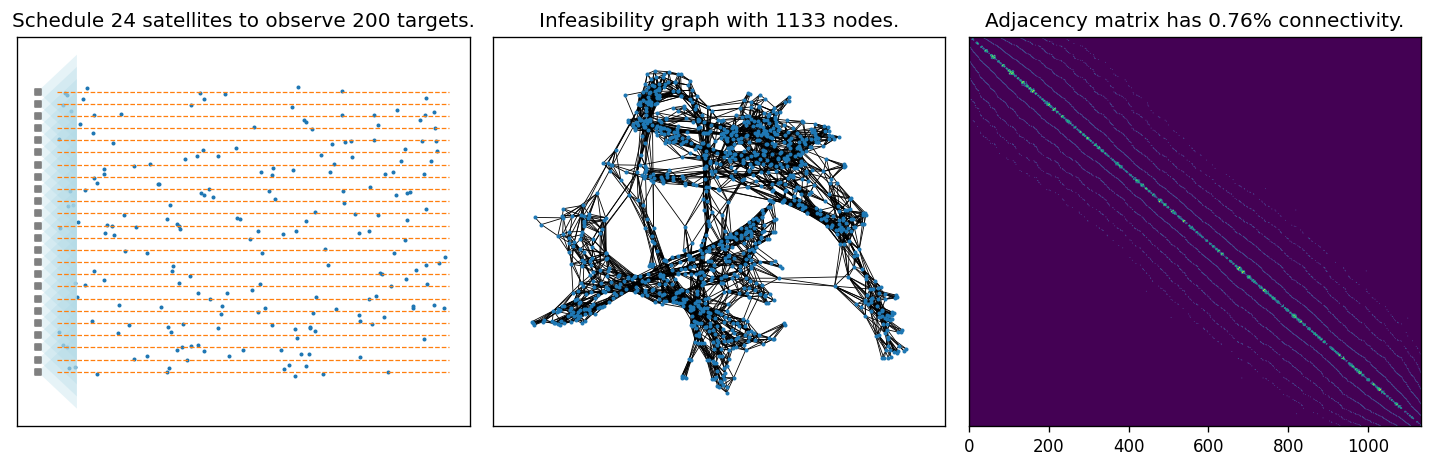

In [2]:
schedule = SatelliteScheduleProblem(
    num_satellites=24,
    num_requests=200
)
schedule.generate(42)
schedule.plot_problem()

Host: network reached target cost -198.


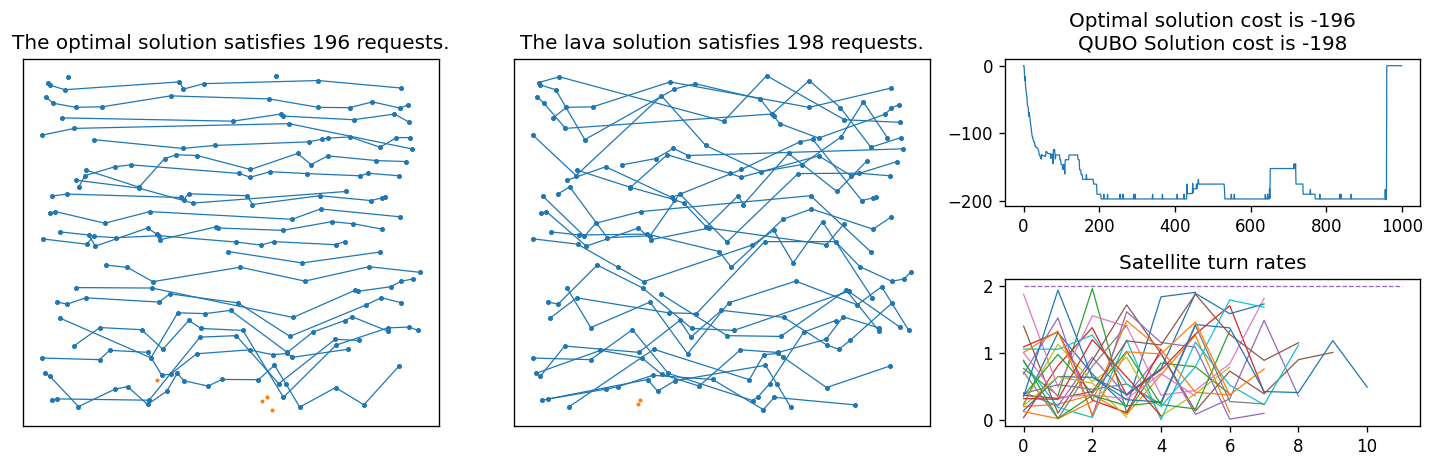

In [3]:
schedule.solve_with_netx()
schedule.set_qubo_hyperparameters()
schedule.solve_with_lava_qubo()
schedule.plot_solutions()